In [ ]:
import numpy as np
import random
import torch
import torch.nn as nn
import gymnasium as gym
import time
from tqdm import tqdm
import winsound
from torch.distributions import Normal, Categorical
from copy import deepcopy

from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy

import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns

from IPython.display import display, clear_output

sns.set()

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 6.0)

%load_ext autoreload
%autoreload 2

### MyGym

In [ ]:
class FlatOrientation(gym.Env):
    def __init__(
            self, 
            t_start: int = 0, 
            t_end: int = 1,
            dt: float = 0.1, 
            R1: int = 1000,
            R2: int = 1000,
            max_action: int = 25,
            observable_states: list = [0, 1, 2],
            ic_boundaries: list = [[-0.5, 0.5], [-0.5, 0.5]]
    ):

        self.t_start = t_start
        self.t_end = t_end
        self.dt = dt

        self.R1 = R1
        self.R2 = R2
        self.max_action = max_action

        self.ic_boundaries = np.array(ic_boundaries)

        self.observable_states = observable_states
        low = np.array([0, -5, -5])
        high = np.array([1, 5, 5])

        self.observation_space = gym.spaces.Box(
            low=low[observable_states], 
            high=high[observable_states], 
            dtype=np.float32
        )

        self.action_space = gym.spaces.Box(
            low=-self.max_action, high=self.max_action, shape=(1,), dtype=np.float32
        )

    def reset(self, seed=None, options=None):
        self.state = np.array([0] + [np.random.uniform(x[0], x[1]) for x in self.ic_boundaries])
        return self.state[self.observable_states], {}
    
    def step(self, u):
        t_next = self.state[0] + self.dt
        x_curr = self.state[1:]
        df_dt = np.array([self.state[2], u[0]])
        x_next = self.integration(x_curr, df_dt)
        self.state = np.hstack((t_next, x_next)) 

        if np.isclose(t_next, self.t_end):
            reward = - self.R1 * (self.state[1] - np.pi)**2 - self.R2 * self.state[2]**2
            done = True

        else:
            reward = - self.dt * u[0]**2
            done = False

        return self.state[self.observable_states], reward, False, done, {}

    def integration(self, x_curr, df_dt, method='Euler'):
        if method == 'Euler':
            x_next = df_dt * self.dt + x_curr
            return x_next


In [ ]:
def get_trajectory(env, agent, initial_state=None, prediction=False, visualize=False, filename='gym_animation.gif', sb3=False):
    trajectory = {'states':[], 'actions': [], 'rewards': [], 'dones': []}
    
    if initial_state is None:
        state = env.reset()[0]
    else:
        env.reset()
        env.state = initial_state
        state = initial_state

    frames = []
    while True:

        trajectory['states'].append(state)

        if sb3 == True:
            action, _ = agent.predict(state, deterministic=True)
        else:
            action = agent.get_action(state, prediction=prediction)
        
        trajectory['actions'].append(action)

        if sb3 == True:
            next_state, reward, _, done, _ = env.step(action)
        else:
            next_state, reward, _, done, _ = env.step(agent.max_action * action)

        trajectory['rewards'].append(reward)
        trajectory['dones'].append(done)

        state = next_state

        if done:
            break

        if visualize:
            frames.append(env.render(mode="rgb_array"))

    if visualize:
        save_frames_as_gif(frames, filename=filename)

    trajectory['states'].append(state)

    return trajectory

In [ ]:
def validation(env, agent, validation_n, prediction=False, sb3=False):
    total_rewards = []
    for _ in range(validation_n):
        trajectory = get_trajectory(env, agent, prediction=prediction, sb3=sb3)
        total_rewards.append(np.sum(trajectory['rewards']))

    return np.mean(total_rewards)

## Ориентация КА, stable_baselines3, PPO

In [ ]:
dt = 1e-2

ic_boundaries = np.array([[0, 0], [-0.5, 0.5], [-0.5, 0.5]])

R1 = 1000
R2 = 1000

max_action = 50

env = FlatOrientation(dt=dt, ic_boundaries=ic_boundaries, R1=R1, R2=R2, max_action=max_action)

In [ ]:
agent = PPO(
    'MlpPolicy', 
    env,
    learning_rate=1e-2,
    gamma=1,
    batch_size=128,
    clip_range=0.5,
    verbose=0
)

# def __init__(self, state_dim, action_dim, max_action, gamma=0.999, batch_size=128, 
#                 epsilon=0.1, epoch_n=30, pi_lr=3e-4, v_lr=3e-4):
# 
# episode_n = 100
# trajectory_n = 100
# 
# agent.gamma = 1
# agent.batch_size = 128 
# agent.epsilon = 0.2
# agent.epoch_n = 10
# agent.pi_lr = 1e-4 # 1e-4
# agent.v_lr = 1e-4 # 1e-4

### Обучение

In [ ]:
agent.learn(total_timesteps=5*int(10e3), progress_bar=False)
winsound.Beep(1440, 200)    

In [ ]:
mean_reward, std_reward = evaluate_policy(agent, agent.get_env(), n_eval_episodes=10)
mean_reward, std_reward

(-10101.179737299999, 2240.320708457448)

### Валидация

In [ ]:
validation_env = FlatOrientation(dt=1e-2, ic_boundaries=np.array([[0, 0], [-0.5, 0.5], [-0.5, 0.5]]))

In [ ]:
validation_score = validation(env, agent, validation_n=10, prediction=True, sb3=True)
print(f'PPO, default advantage, validation_score: {validation_score}')

PPO, default advantage, validation_score: -8812.79846898442

### Управление:

In [ ]:
def get_reward(env, agent):
    traj = get_trajectory(env, agent, prediction=True, initial_state=np.array([0, 0, 0]), sb3=True)
    actions = np.array(traj['actions'])
    u = actions
    t = np.arange(env.t_start, env.t_end + env.dt, env.dt)
    integral_part = np.trapz((u**2).squeeze(), t[:-1])
    
    states = np.array(traj['states'])
    terminal_part = env.R1 * (states[-1, 1] - np.pi)**2 + env.R2 * states[-1, 2]**2

    return integral_part + terminal_part

In [ ]:
get_reward(env, agent)

10585.006168190826

In [ ]:
def plot_u(env, agent):
    traj = get_trajectory(env, agent, prediction=True, initial_state=np.array([0, 0]), sb3=True)
    actions = np.array(traj['actions'])
    u = actions
    t = np.arange(env.t_start, env.t_end + env.dt, env.dt)

    plt.plot(t[:-1], u, label='u')
    plt.legend()

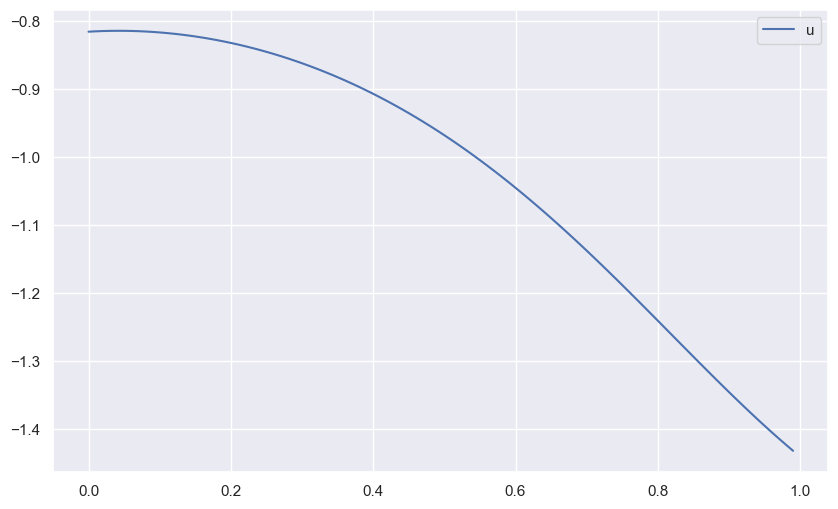

In [ ]:
plot_u(validation_env, agent)

In [ ]:
def plot_sheaf(env, agent, n, initial_state=None):
    for _ in range(n):
        traj = get_trajectory(env, agent, prediction=True, initial_state=initial_state, sb3=True)
        t = np.arange(env.t_start, env.t_end + env.dt, env.dt)
        states = np.array(traj['states'])
        x1 = states[:, 1]
        x2 = states[:, 2]
        
        kwargs_x1 = {'color': 'blue'}
        kwargs_x2 = {'color': 'orange'}
        plt.plot(t, x1, **kwargs_x1)
        plt.plot(t, x2, **kwargs_x2)

    plt.plot([], [], label=r'$ x_1 $', **kwargs_x1)
    plt.plot([], [], label=r'$ x_2 $', **kwargs_x2)
    plt.title('Bundle of Trajectories')
    plt.xlabel('t')
    plt.legend()

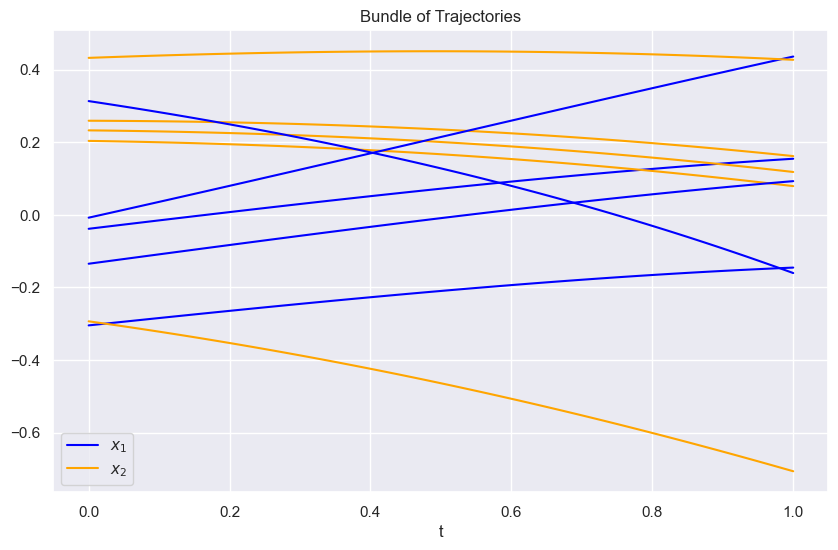

In [ ]:
plot_sheaf(validation_env, agent, 5)

## Ориентация КА, SAC

### SAC

In [ ]:
class SAC(nn.Module):
    def __init__(self, state_dim, action_dim, max_action,
                 gamma=0.99, alpha=1e-3, tau=1e-2, 
                 batch_size=64, pi_lr=1e-3, q_lr=1e-3):
        super().__init__()

        self.pi_model = nn.Sequential(nn.Linear(state_dim, 128), nn.ReLU(), 
                                      nn.Linear(128, 128), nn.ReLU(), 
                                      nn.Linear(128, 2 * action_dim), nn.Tanh())

        self.q1_model = nn.Sequential(nn.Linear(state_dim + action_dim, 128), nn.ReLU(), 
                                      nn.Linear(128, 128), nn.ReLU(), 
                                      nn.Linear(128, 1))

        self.q2_model = nn.Sequential(nn.Linear(state_dim + action_dim, 128), nn.ReLU(), 
                                      nn.Linear(128, 128), nn.ReLU(), 
                                      nn.Linear(128, 1))

        self.max_action = max_action

        self.gamma = gamma
        self.alpha = alpha
        self.tau = tau
        self.batch_size = batch_size
        self.memory = []

        self.softmax = nn.Softmax()

        self.pi_optimizer = torch.optim.Adam(self.pi_model.parameters(), pi_lr)
        self.q1_optimizer = torch.optim.Adam(self.q1_model.parameters(), q_lr)
        self.q2_optimizer = torch.optim.Adam(self.q2_model.parameters(), q_lr)

        self.q1_target_model = deepcopy(self.q1_model)
        self.q2_target_model = deepcopy(self.q2_model)


    def get_action(self, state, prediction=False):
        state = torch.FloatTensor(state).unsqueeze(0)
        action, _ = self.predict_actions(state, prediction)
        return action.squeeze(1).detach().numpy()


    def fit(self, state, action, reward, done, next_state):
        self.memory.append([state, action, reward, done, next_state])

        if len(self.memory) > self.batch_size:
            batch = random.sample(self.memory, self.batch_size)
            states, actions, rewards, dones, next_states = map(torch.FloatTensor, zip(*batch))
            rewards, dones = rewards.unsqueeze(1), dones.unsqueeze(1)

            next_actions, next_log_probs = self.predict_actions(next_states)
            
            next_states_and_actions = torch.concatenate((next_states, next_actions), dim=1)
            next_q1_values = self.q1_target_model(next_states_and_actions)
            next_q2_values = self.q2_target_model(next_states_and_actions)
            next_min_q_values = torch.min(next_q1_values, next_q2_values)
            targets = rewards + self.gamma * (1 - dones) * (next_min_q_values - self.alpha * next_log_probs)

            states_and_actions = torch.concatenate((states, actions), dim=1)
            q1_loss = torch.mean((self.q1_model(states_and_actions) - targets.detach()) ** 2)
            q2_loss = torch.mean((self.q2_model(states_and_actions) - targets.detach()) ** 2)
            self.update_model(q1_loss, self.q1_optimizer, self.q1_model, self.q1_target_model)
            self.update_model(q2_loss, self.q2_optimizer, self.q2_model, self.q2_target_model)

            pred_actions, log_probs = self.predict_actions(states)
            states_and_pred_actions = torch.concatenate((states, pred_actions), dim=1)
            q1_values = self.q1_model(states_and_pred_actions)
            q2_values = self.q2_model(states_and_pred_actions)
            min_q_values = torch.min(q1_values, q2_values)
            pi_loss = - torch.mean(min_q_values - self.alpha * log_probs)
            self.update_model(pi_loss, self.pi_optimizer)
            
    def update_model(self, loss, optimizer, model=None, target_model=None):
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if model != None and target_model != None:
            for param, terget_param in zip(model.parameters(), target_model.parameters()):
                new_terget_param = (1 - self.tau) * terget_param + self.tau * param
                terget_param.data.copy_(new_terget_param)

    def predict_actions(self, states, prediction=False):
        means, log_stds = self.pi_model(states).T
        means, log_stds = means.unsqueeze(1), log_stds.unsqueeze(1)
        if prediction is False:
            dists = Normal(means, torch.exp(log_stds))
            actions = dists.rsample()
            log_probs = dists.log_prob(actions)
        else:
            actions = means
            log_probs = {}

        return actions, log_probs

In [ ]:
def train_sac(env, agent, episode_n, trajectory_len=200):
    total_rewards = []
    for episode in tqdm(range(episode_n)):

        total_reward = 0
        state = env.reset()[0]
        
        while True:
            action = agent.get_action(state)
            next_state, reward, _, done, _ = env.step(action)
        
            agent.fit(state, action, reward, done, next_state)

            total_reward += reward
            state = next_state

            if done:
                break

        total_rewards.append(total_reward)

    return total_rewards

In [ ]:
dt = 1e-1
ic_boundaries=np.array([[0, 0], [-0.5, 0.5], [-0.5, 0.5]])
R1 = 1000
R2 = 1000

env = FlatOrientation(dt=dt, ic_boundaries=ic_boundaries, R1=R1, R2=R2)

state_dim = 3
action_dim = 1
max_action = 25

### Обучение

In [ ]:
agent = SAC(state_dim, action_dim, max_action)

Обучение: (6 мин)

Выбранные гиперпараметры:

```python
episode_n = 200

gamma=0.99 
alpha=1e-3
tau=1e-2
batch_size=64
pi_lr=1e-3
q_lr=1e-3
```

In [ ]:
episode_n = 10000

gamma=1
alpha=1e-3
tau=1e-2
batch_size=128
pi_lr=1e-4
q_lr=1e-4

In [ ]:
rewards = train_sac(env, agent, episode_n)

100%|██████████| 10000/10000 [25:11<00:00,  6.62it/s]


In [ ]:
history = []
history.extend(rewards)

In [ ]:
smoothed_history = np.zeros_like(history)
smoothed_history[0] = history[0]

alpha = 0.1

for i in range(1, smoothed_history.size):
    smoothed_history[i] = alpha * history[i] + (1 - alpha) * smoothed_history[i - 1]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


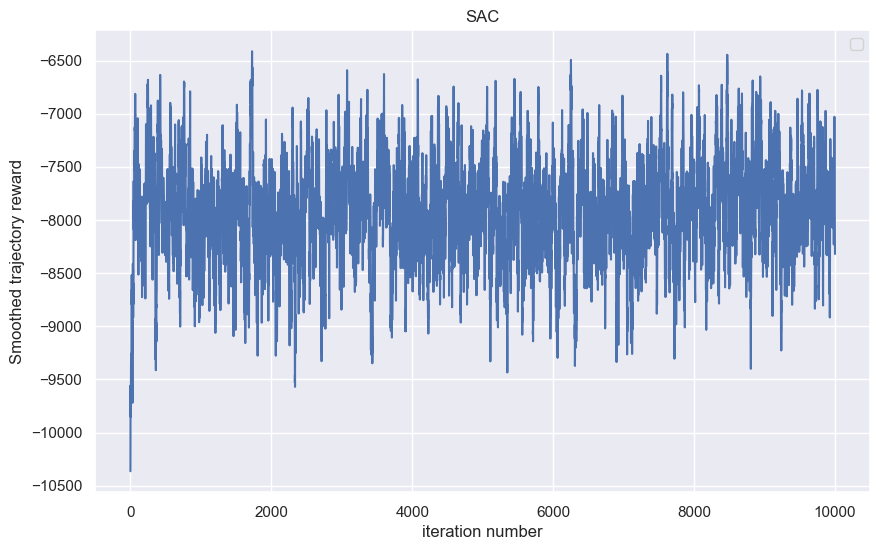

In [ ]:
plt.title('SAC')
plt.xlabel('iteration number')
plt.ylabel('Smoothed trajectory reward')
plt.legend()

plt.plot(smoothed_history)

### Валидация

In [ ]:
class AnaliticalAgent():
    def __init__(self, env):
        self.max_action = 25
        self.t = np.arange(0, 1 + env.dt, env.dt)
        self.u = (6 * np.pi - 12 * np.pi * self.t) / self.max_action
        self.i = 0

    def get_action(self, state, prediction=False):
        self.i += 1
        return self.u[self.i].reshape(1)

    def plot(self):
        plt.plot(self.t, self.u)

In [ ]:
validation_env = FlatOrientation(dt=1e-3, ic_boundaries=np.array([[0, 0], [-0.5, 0.5], [-0.5, 0.5]]))
# validation_env = env

In [ ]:
validation_score = validation(validation_env, agent, validation_n=10, prediction=True)
print(f'SAC, validation_score: {validation_score}')

SAC, validation_score: -5452.988716177819


### Управление:

In [ ]:
def get_reward(env, agent):
    traj = get_trajectory(env, agent, prediction=False, initial_state=np.array([0, 0, 0]))
    actions = np.array(traj['actions'])
    u = agent.max_action * actions
    t = np.arange(env.t_start, env.t_end + env.dt, env.dt)
    integral_part = np.trapz((u**2).squeeze(), t[:-1])
    
    states = np.array(traj['states'])
    terminal_part = env.R1 * (states[-1, 1] - np.pi)**2 + env.R2 * states[-1, 2]**2

    return integral_part + terminal_part

In [ ]:
get_reward(validation_env, agent)

5233.700789314499

In [ ]:
get_reward(validation_env, AnaliticalAgent(validation_env))

118.52490762831876

In [ ]:
def plot_u(env, agent):
    traj = get_trajectory(env, agent, prediction=True, initial_state=np.array([0, 0, 0]))
    actions = np.array(traj['actions'])
    u = agent.max_action * actions
    t = np.arange(env.t_start, env.t_end + env.dt, env.dt)

    plt.ylim([-agent.max_action - 1, agent.max_action + 1])
    plt.plot(t[:-1], u, label='u')
    plt.legend()

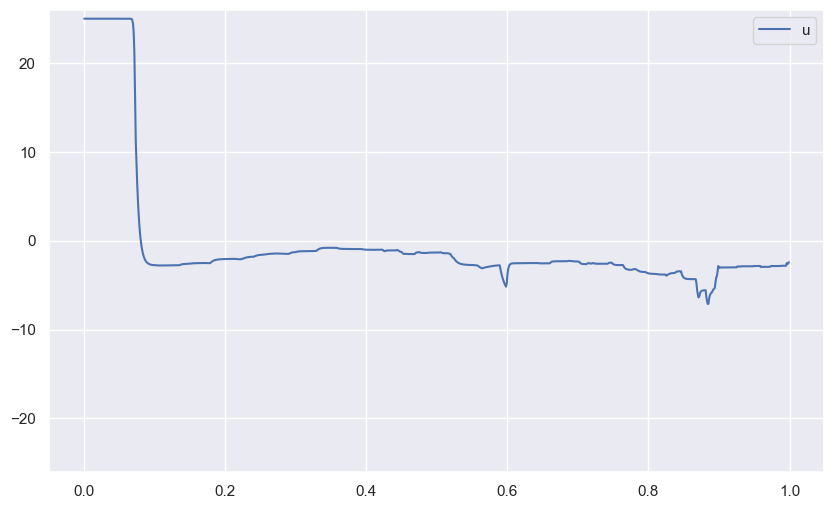

In [ ]:
plot_u(validation_env, agent)

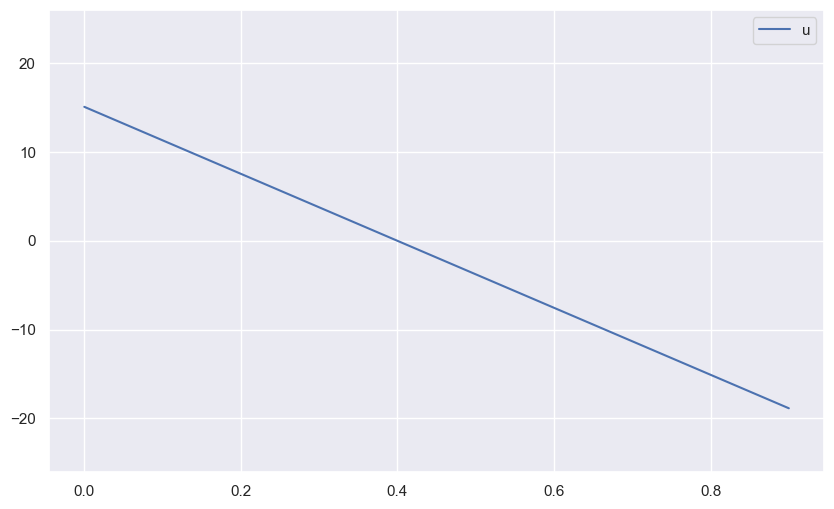

In [ ]:
plot_u(env, AnaliticalAgent(env))

In [ ]:
def plot_sheaf(env, agent, n, initial_state=None):
    for _ in range(n):
        traj = get_trajectory(env, agent, prediction=True, initial_state=initial_state)
        t = np.arange(env.t_start, env.t_end + env.dt, env.dt)
        states = np.array(traj['states'])
        x1 = states[:, 1]
        x2 = states[:, 2]
        
        kwargs_x1 = {'color': 'blue'}
        kwargs_x2 = {'color': 'orange'}
        plt.plot(t, x1, **kwargs_x1)
        plt.plot(t, x2, **kwargs_x2)

    plt.ylim([-1, 6])
    plt.plot([], [], label=r'$ x_1 $', **kwargs_x1)
    plt.plot([], [], label=r'$ x_2 $', **kwargs_x2)
    plt.title('Bundle of Trajectories')
    plt.xlabel('t')
    plt.legend()

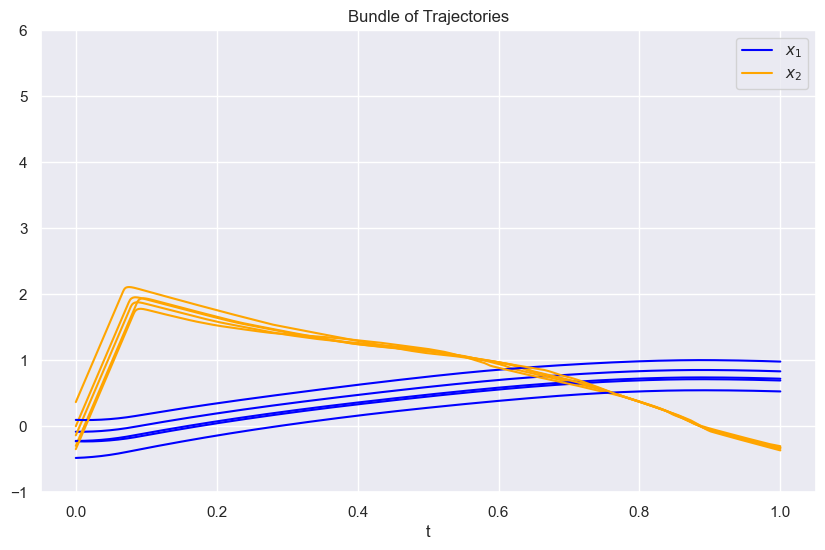

In [ ]:
plot_sheaf(validation_env, agent, 5)

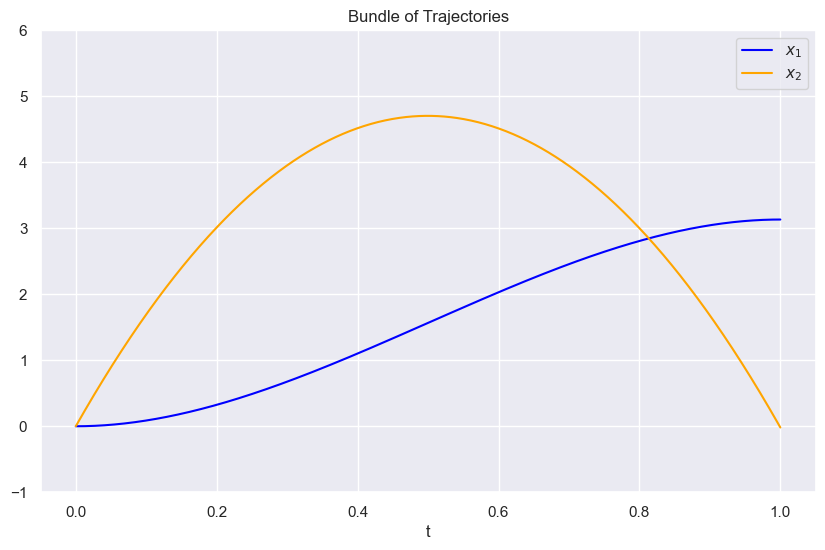

In [ ]:
plot_sheaf(validation_env, AnaliticalAgent(validation_env), 1, np.array([0, 0, 0]))

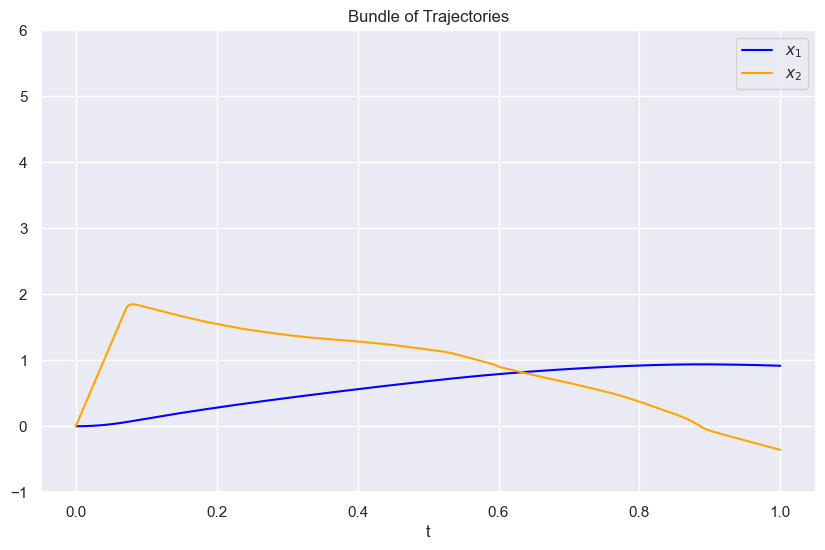

In [ ]:
plot_sheaf(validation_env, agent, 1, np.array([0, 0, 0]))

In [ ]:
# torch.save(agent.pi_model, 'flat_orientation_pi_160.pth')
# torch.save(agent.v_model, 'flat_orientation_v_160.pth')

## Pendulum-v1 

In [ ]:
env = gym.make('Pendulum-v1')

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

In [ ]:
pendulum_agent = PPO(state_dim, action_dim, max_action=2)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
pendulum_agent.pi_model = torch.load('pendulum_pi_model.pth')
pendulum_agent.v_model = torch.load('pendulum_v_model.pth')

### Обучение

In [ ]:
episode_n = 25
trajectory_n = 20

pendulum_agent.gamma = 0.9
pendulum_agent.batch_size = 128 
pendulum_agent.epsilon = 0.2
pendulum_agent.epoch_n = 30 
pendulum_agent.pi_lr = 1e-4 
pendulum_agent.v_lr = 5e-4

In [ ]:
ppo_default_history = []

In [ ]:
ppo_default_rewards = train_ppo(env, pendulum_agent, episode_n, trajectory_n, advantage='default')

In [ ]:
#torch.save(pendulum_agent.pi_model, 'pendulum_pi_model.pth')
#torch.save(pendulum_agent.v_model, 'pendulum_v_model.pth')

In [ ]:
ppo_default_history.extend(ppo_default_rewards)

График обучения:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


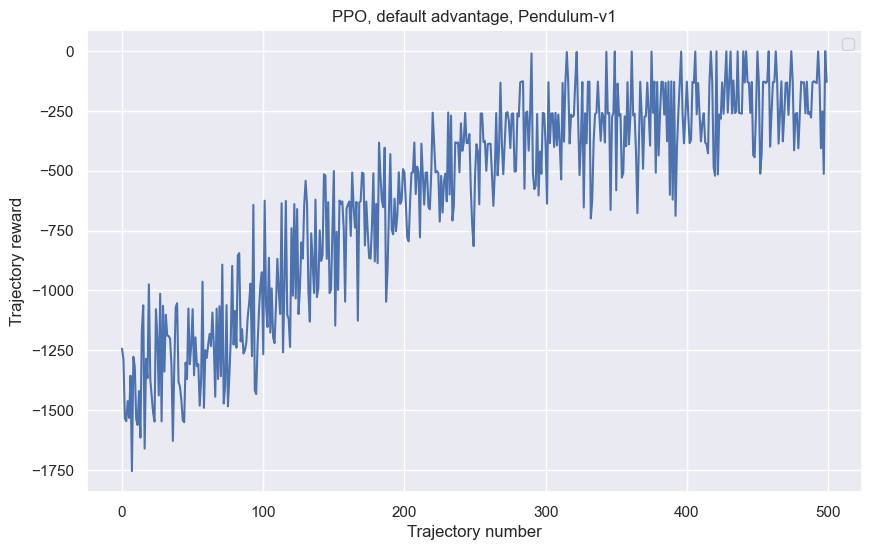

In [ ]:
plt.title('PPO, default advantage, Pendulum-v1')
plt.xlabel('Trajectory number')
plt.ylabel('Trajectory reward')
plt.legend()

plt.plot(ppo_default_history)

### Валидация

In [ ]:
validation_n = 100

validation_score = validation(env, pendulum_agent, validation_n)
print(f'PPO, default advantage, validation_score: {validation_score}')

PPO, default advantage, validation_score: -228.23738591192188


### Управление:

In [ ]:
traj = get_trajectory(env, pendulum_agent, prediction=True)
np.sum(traj['rewards'])

-139.3293101334683

In [ ]:
u = [traj['actions'][i] for i in range(len(traj['actions']))]
u = pendulum_agent.max_action * np.array(u)
t = np.arange(0, 10 + env.dt, env.dt)

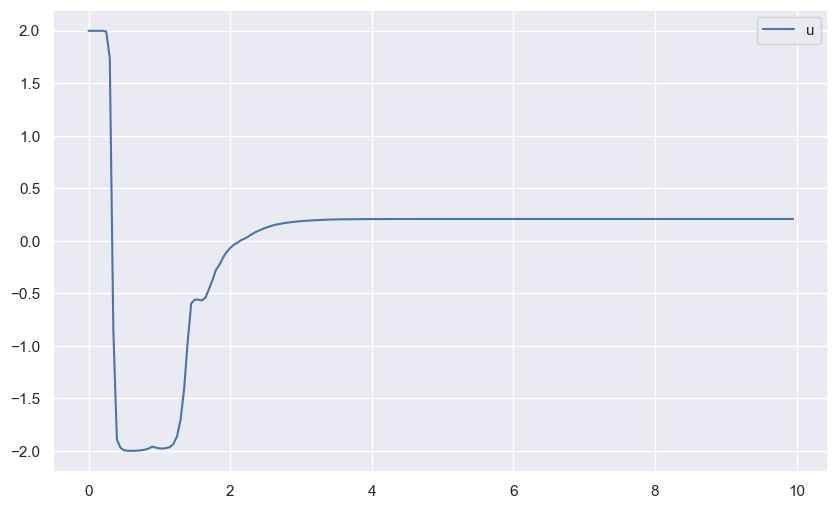

In [ ]:
plt.plot(t[:-1], u, label='u')
plt.legend()

In [ ]:
states = np.array(traj['states'])

In [ ]:
def get_theta(states):
    theta = np.arctan2(states[:, 1], states[:, 0])
    for i in range(theta.size - 1):
        if np.abs(theta[i] - theta[i + 1]) > 0.5:
            if theta[i + 1] > theta[i]:
                theta[i + 1:] -= 2 * np.pi
                continue
            if theta[i + 1] < theta[i]:
                theta[i + 1:] += 2 * np.pi
                continue

    return theta

In [ ]:
theta = get_theta(states)
dtheta_dt = states[:, 2]

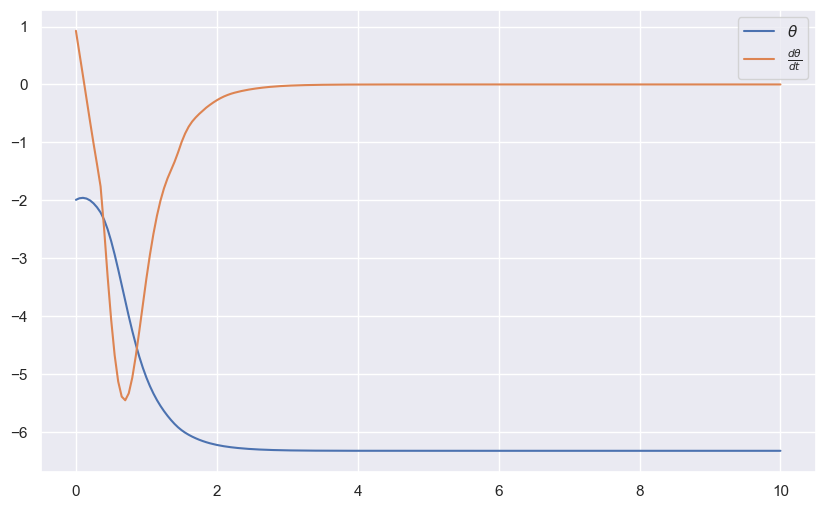

In [ ]:
plt.plot(t, theta, label=r'$ \theta $')
plt.plot(t, dtheta_dt, label=r'$ \frac{d \theta}{dt} $')

plt.legend()

## Pendulum-v1, stable_baselines3

In [ ]:
env = gym.make('Pendulum-v1')

In [ ]:
pendulum_agent = PPO('MlpPolicy', env, verbose=0)

### Обучение

In [ ]:
pendulum_agent.learn(total_timesteps=int(10e4), progress_bar=True)
winsound.Beep(1440, 200)    

Output()

In [ ]:
mean_reward, std_reward = evaluate_policy(pendulum_agent, pendulum_agent.get_env(), n_eval_episodes=10)
mean_reward, std_reward

(-1240.5858371000002, 149.724775134554)

### Валидация

In [ ]:
validation_score = validation(env, pendulum_agent, validation_n=10, sb3=True)
print(f'PPO, default advantage, validation_score: {validation_score}')

winsound.Beep(1440, 200)    

PPO, default advantage, validation_score: -1121.8828891684277


### Управление:

In [ ]:
traj = get_trajectory(env, pendulum_agent, prediction=True, sb3=True)
np.sum(traj['rewards'])

-1118.7621084361228

In [ ]:
u = [traj['actions'][i] for i in range(len(traj['actions']))]
u = np.array(u)
t = np.arange(0, 10 + env.dt, env.dt)

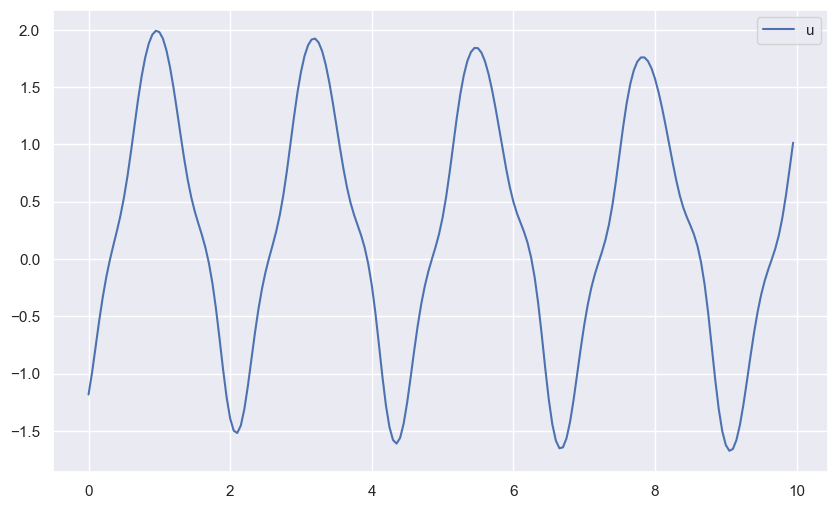

In [ ]:
plt.plot(t[:-1], u, label='u')
plt.legend()

In [ ]:
states = np.array(traj['states'])

In [ ]:
def get_theta(states):
    theta = np.arctan2(states[:, 1], states[:, 0])
    for i in range(theta.size - 1):
        if np.abs(theta[i] - theta[i + 1]) > 0.5:
            if theta[i + 1] > theta[i]:
                theta[i + 1:] -= 2 * np.pi
                continue
            if theta[i + 1] < theta[i]:
                theta[i + 1:] += 2 * np.pi
                continue

    return theta

In [ ]:
theta = get_theta(states)
dtheta_dt = states[:, 2]

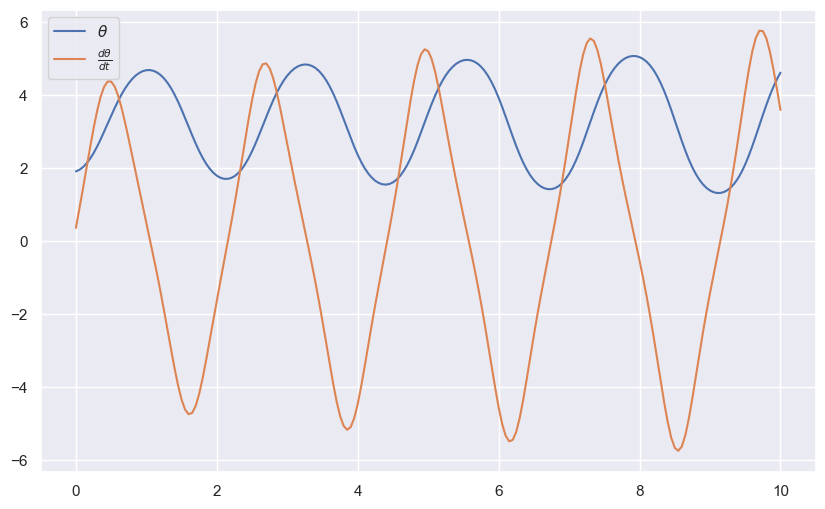

In [ ]:
plt.plot(t, theta, label=r'$ \theta $')
plt.plot(t, dtheta_dt, label=r'$ \frac{d \theta}{dt} $')

plt.legend()